In [112]:
from graph_tool.generation import *
from graph_tool.correlations import *
from graph_tool.stats import *
from graph_tool.draw import graph_draw
from graph_tool.collection import *
from graph_tool.topology import *
from graph_tool.inference import *
from graph_tool.spectral import *
import numpy as np
import matplotlib.pyplot as plt

In [226]:
# number of nodes
N = int(1e4)

# hospital layer size
fhosp = 0.05
Nhosp = int(fhosp*N)

# city layer size
Ncity = N-Nhosp

number nodes 500
number edges 2495


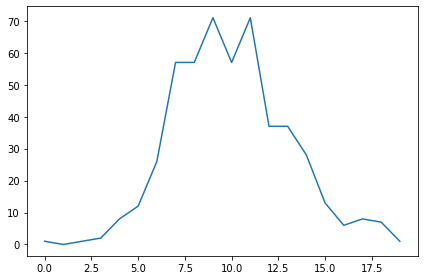

In [227]:
n = Nhosp
p = 10/Nhosp
m = int(p*Nhosp*(Nhosp-1)/2)

print("number nodes", n)
print("number edges", m)

ak = np.floor(2 * m / n)
dm = 2 * m - ak * n

ER = random_graph(n, lambda i: ak + 1 if i < dm else ak, directed=False, random=False) 

ret = random_rewire(ER, 'erdos', n_iter = 1)

degree_hist = vertex_hist(ER, "total")

plt.figure()

plt.plot(degree_hist[1][:-1], degree_hist[0])

plt.tight_layout()

plt.show()

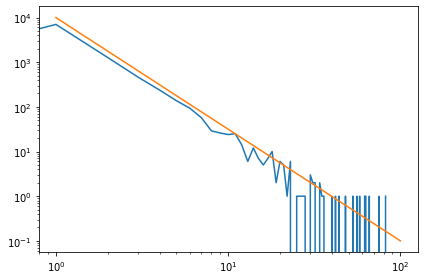

In [228]:
def sample_k(max):

    accept = False

    while not accept:

        k = np.random.randint(1,max+1)

        accept = np.random.random() < 1.0/k**2.5

    return k

SF = random_graph(Ncity, lambda: sample_k(100), directed=False, model = 'configuration', n_iter=100)

degree_hist = vertex_hist(SF, "total")

xx = np.linspace(1, 100)

plt.figure()

plt.plot(degree_hist[1][:-1], degree_hist[0])

plt.plot(xx, 1e4*xx**-2.5)

plt.xscale('log')
plt.yscale('log')

plt.tight_layout()

plt.show()

500


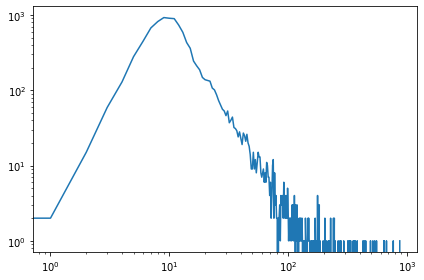

In [232]:
# generate SBM

ER_out = ER.get_out_degrees(ER.get_vertices())

SF_out = SF.get_out_degrees(SF.get_vertices())

groups = np.asarray([0 if x < Nhosp else 1 for x in range(N)])

in_d = np.append(ER_out,SF_out)

out_d = np.append(ER_out,SF_out)

pmatrix = np.asarray([[Nhosp*10,Nhosp*10*0.25],[Nhosp*10*0.25,Ncity*10*np.mean(SF_out)]])

print(Nhosp)
u = generate_sbm(groups, pmatrix, in_degs = in_d, out_degs = out_d, directed = False)

degree_hist = vertex_hist(u, "total")

#print(degree_hist[1][:-1], degree_hist[0])

plt.figure()

plt.plot(degree_hist[1][:-1], degree_hist[0])

plt.xscale('log')
plt.yscale('log')
plt.tight_layout()

plt.show()

A = adjacency(u)

Mc=A.tocoo()

np.savetxt('edge_list.txt', np.c_[Mc.row,Mc.col])

In [ ]:
graph_draw(u, output="graph.pdf")